# CS 342 Final Project - Letter Recognition CNN

Mrityunjay Mishra, Mihir Suvarna, Daniel Sialm

## Project Description

This project aims to create a convolutional neural network (CNN) for the task of letter recognition. The task of letter recognition, or more generally speaking, text recognition (also known as optical character recognition, or OCR) has gained much importance in recent years due to emerging applications. For example, OCR software can be used to convert handwritten text into digital text and robots use cameras to read signs in their environment. Due to the increasing importance of the task of text recognition, we aim to create a robust CNN that is able to correctly classify handwritten and digital letters.

In [1]:
# Run these two blocks to load important libraries and set things up
import torch
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Dataset

In [2]:
letter_to_label = dict()
classes_collected = ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
for i in range(len(classes_collected)):
    letter_to_label[classes_collected[i]] = i
print(letter_to_label)

{'N/A': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [72]:
import os
import shutil
import glob

from PIL import Image
import torchvision.transforms as transforms

src_dir = 'dataset'
transform = transforms.ToTensor()

files_train = []
files_val = []
files_test = []
for i in range(0,16): files_train.append('P' + str(i))
for i in range(16,21): files_val.append('P' + str(i))
for i in range(21,24): files_test.append('P' + str(i))

imgs_train = []
imgs_val = []
imgs_test = []
labels_train = []
labels_val = []
labels_test = []
for f in glob.glob(os.path.join(src_dir, '*.png')):
    ftitle, fext = os.path.splitext(os.path.basename(f))
    letter = ftitle.split("_")[1].lower()
    file = ftitle.split("_")[0].split("-")[0]
    im = Image.open(f).convert('L')

    if file in files_train:
        imgs_train.append(transform(im).detach().numpy())
        labels_train.append(letter_to_label[letter])
    elif file in files_val:
        imgs_val.append(transform(im).detach().numpy())
        labels_val.append(letter_to_label[letter])
    elif file in files_test:
        imgs_test.append(transform(im).detach().numpy())
        labels_test.append(letter_to_label[letter])
    
data_train = torch.tensor(imgs_train)
data_val = torch.tensor(imgs_val)
data_test = torch.tensor(imgs_test)
labels_train = torch.tensor(np.array(labels_train))
labels_val = torch.tensor(np.array(labels_val))
labels_test = torch.tensor(np.array(labels_test))

print(data_train.shape, data_val.shape, data_test.shape)
print(labels_train.shape, labels_val.shape, labels_test.shape)

torch.Size([4160, 1, 28, 28]) torch.Size([1300, 1, 28, 28]) torch.Size([780, 1, 28, 28])
torch.Size([4160]) torch.Size([1300]) torch.Size([780])


['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Label: m


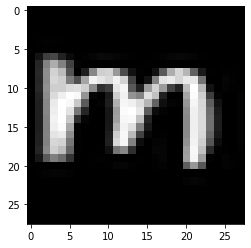

In [73]:
# Data visualization

# print classes
print(classes_collected)
# print label
index = 125
plt.imshow(data_train[index].reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes_collected[labels_train[index].item()])

In [74]:
batch_size = 64

train_set_collected = torch.utils.data.TensorDataset(data_train, labels_train)
val_set_collected = torch.utils.data.TensorDataset(data_val, labels_val)
test_set_collected = torch.utils.data.TensorDataset(data_test, labels_test)

train_loader_collected = torch.utils.data.DataLoader(train_set_collected, batch_size=batch_size, shuffle=True)
val_loader_collected = torch.utils.data.DataLoader(val_set_collected, batch_size=batch_size, shuffle=True)
test_loader_collected = torch.utils.data.DataLoader(test_set_collected, batch_size=batch_size, shuffle=True)

## Defining a basic LetterCNN

In [75]:
class letterCNN(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

In [76]:
# Testing the model above, TODO remove before submission
model_test = letterCNN(classes_collected)
for inputs, labels in train_loader_collected:
    print(inputs.shape)
    print(labels.shape)
    print(inputs.dtype, labels.dtype)
    outputs = model_test.forward(inputs)
    print(outputs.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.float32 torch.int64
torch.Size([64, 27])


## Testing the basic LetterCNN

In [77]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model.forward(inputs)
                labels = labels.type(torch.long)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model.forward(inputs)
                    labels = labels.type(torch.long)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

def test_network(model, test_loader):
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        for inputs, labels  in test_loader:
            outputs = model.forward(inputs)
            predicted = torch.argmax(outputs, dim=1) # get predicted class label for each test example.
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

def display_contingency_matrix(num_classes, pred, true):
    contingency = np.zeros((num_classes, num_classes))
    for i in range(len(pred)):
        contingency[int(pred[i])][int(true[i])] += 1

    plt.matshow(contingency)
    plt.xlabel("true")
    plt.ylabel("predictions")
    plt.colorbar()

In [78]:
model1 = letterCNN(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)
train_network(model1, train_loader_collected, val_loader_collected, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 2.44099
   Val loss: 2.32987

EPOCH 1
 Train loss: 1.06285
   Val loss: 2.07849

EPOCH 2
 Train loss: 0.61417
   Val loss: 2.18789

EPOCH 3
 Train loss: 0.38804
   Val loss: 2.32227

EPOCH 4
 Train loss: 0.24358
   Val loss: 2.49655

EPOCH 5
 Train loss: 0.15999
   Val loss: 2.70679

EPOCH 6
 Train loss: 0.10904
   Val loss: 2.77044

EPOCH 7
 Train loss: 0.07725
   Val loss: 2.90544

EPOCH 8
 Train loss: 0.05701
   Val loss: 3.02442

EPOCH 9
 Train loss: 0.04339
   Val loss: 3.11692



Test accuracy: 53.846


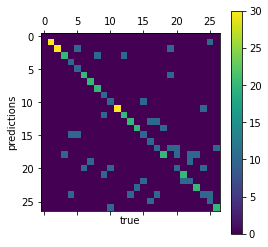

In [79]:
acc, true, pred = test_network(model1, test_loader_collected)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model1.classes), pred, true)

We can see that there is quite a bit of overfitting going on. Also, our accuracy is quite low. While this accuracy is still quite good - $48.718 / (1 / 26) = 12.67$ times increase in accuracy from just taking a random guess - we can still do better. The reason for this poor performance is because only a few people's data was obtained which. This ends up heavily overrepresenting our training dataset towards the handwriting of a few people. Consequently, our model does not generalize well. We can also see this from the increasing validation loss. 

Thus, we will combine our dataset with the EMNIST dataset to create a better model.

### EMNIST Data Set

In [80]:
from torchvision import datasets, transforms

save_dir = 'letterEMNIST'

transform = transforms.ToTensor() # Convert the image into a torch tensor.

train_set = datasets.EMNIST(save_dir, split="letters", download=True, train=True, transform=transform)
test_set = datasets.EMNIST(save_dir, split="letters", download=True, train=False, transform=transform)

print(train_set)
print(test_set)

Dataset EMNIST
    Number of datapoints: 124800
    Root location: letterEMNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset EMNIST
    Number of datapoints: 20800
    Root location: letterEMNIST
    Split: Test
    StandardTransform
Transform: ToTensor()


In [81]:
from torch.utils.data.sampler import SubsetRandomSampler
ntotal = 60000
ntrain = int(0.78*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

In [82]:
# initialize the data sets
batch_size = 1
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Label: w


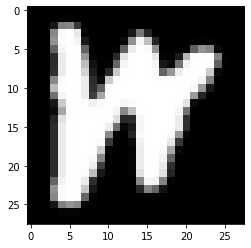

In [83]:
# Visualizing EMNIST

# print classes
print(train_set.classes)
classes = train_set.classes
# print label
index = 0
plt.imshow(train_set.data[index].T, cmap='Greys_r')
print("Label: %s" % train_set.classes[train_set.targets[index]])

### Combining EMNIST with our Data

In [85]:
combined_batch_size=64

combined_train = []
combined_train_labels = []
combined_val = []
combined_val_labels = []
combined_test = []
combined_test_labels = []

for inputs, labels in train_loader:
    combined_train.append( inputs[0].detach().numpy() )
    combined_train_labels.append( labels[0].item() )
for inputs, labels in train_loader_collected:
    for i in range(inputs.shape[0]):
        combined_train.append( inputs[i].detach().numpy() )
        combined_train_labels.append( labels[i].item() )
        
for inputs, labels in val_loader:
    combined_val.append( inputs[0].detach().numpy() )
    combined_val_labels.append( labels[0].item() )
for inputs, labels in val_loader_collected:
    for i in range(inputs.shape[0]):
        combined_val.append( inputs[i].detach().numpy() )
        combined_val_labels.append( labels[i].item() )
        
for inputs, labels in test_loader:
    combined_test.append( inputs[0].detach().numpy() )
    combined_test_labels.append( labels[0].item() )
for inputs, labels in test_loader_collected:
    for i in range(inputs.shape[0]):
        combined_test.append( inputs[i].detach().numpy() )
        combined_test_labels.append( labels[i].item() )

combined_train = np.array(combined_train)
combined_train_labels = np.array(combined_train_labels)
combined_val = np.array(combined_val)
combined_val_labels = np.array(combined_val_labels)
combined_test = np.array(combined_test)
combined_test_labels = np.array(combined_test_labels)

print(combined_train.shape)
print(combined_train_labels.shape)
print(combined_val.shape)
print(combined_val_labels.shape)
print(combined_test.shape)
print(combined_test_labels.shape)

combined_train = torch.Tensor(combined_train)
combined_train_labels = torch.Tensor(combined_train_labels)

combined_val = torch.Tensor(combined_val)
combined_val_labels = torch.Tensor(combined_val_labels)

combined_test = torch.Tensor(combined_test)
combined_test_labels = torch.Tensor(combined_test_labels)


cobined_train_set = torch.utils.data.TensorDataset(combined_train, combined_train_labels)
combined_train_loader = torch.utils.data.DataLoader(cobined_train_set, batch_size=combined_batch_size, shuffle=True)

cobined_val_set = torch.utils.data.TensorDataset(combined_val, combined_val_labels)
combined_val_loader = torch.utils.data.DataLoader(cobined_val_set, batch_size=combined_batch_size, shuffle=True)

cobined_test_set = torch.utils.data.TensorDataset(combined_test, combined_test_labels)
combined_test_loader = torch.utils.data.DataLoader(cobined_test_set, batch_size=combined_batch_size, shuffle=True)

print(len(combined_train_loader))
print(len(combined_val_loader))
print(len(combined_test_loader))

(50960, 1, 28, 28)
(50960,)
(14500, 1, 28, 28)
(14500,)
(21580, 1, 28, 28)
(21580,)
797
227
338


## Making a new LetterCNN on the Combined Dataset

In [86]:
model2 = letterCNN(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
train_network(model2, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.27482
   Val loss: 0.97111

EPOCH 1
 Train loss: 0.77092
   Val loss: 0.80433

EPOCH 2
 Train loss: 0.61850
   Val loss: 0.74387

EPOCH 3
 Train loss: 0.53399
   Val loss: 0.70506

EPOCH 4
 Train loss: 0.48356
   Val loss: 0.68088

EPOCH 5
 Train loss: 0.44046
   Val loss: 0.67761

EPOCH 6
 Train loss: 0.41002
   Val loss: 0.65830

EPOCH 7
 Train loss: 0.38169
   Val loss: 0.66840

EPOCH 8
 Train loss: 0.35896
   Val loss: 0.67321

EPOCH 9
 Train loss: 0.33973
   Val loss: 0.67902



Test accuracy: 84.690


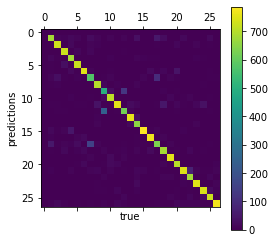

In [87]:
acc, true, pred = test_network(model2, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model2.classes), pred, true)

We not get much better resuls. __TODO Explain more__

## Computational Experiment 1 - Regularization

### 1a) Regularization through data augmentation

In [88]:
src_dir = "dataset_digital"
idx = 0

imgs_train = []
imgs_val = []
imgs_test = []
labels_train = []
labels_val = []
labels_test = []
for f in glob.glob(os.path.join(src_dir, '*.png')):
    ftitle, fext = os.path.splitext(os.path.basename(f))
    letter = ftitle.split("_")[1].lower()
    im = Image.open(f).convert('L')

    if idx < 1820:
        imgs_train.append(transform(im).detach().numpy())
        labels_train.append(letter_to_label[letter])
    elif idx < 2210:
        imgs_val.append(transform(im).detach().numpy())
        labels_val.append(letter_to_label[letter])
    else:
        imgs_test.append(transform(im).detach().numpy())
        labels_test.append(letter_to_label[letter])
    
    idx += 1
        
data_train = torch.tensor(imgs_train)
data_val = torch.tensor(imgs_val)
data_test = torch.tensor(imgs_test)
labels_train = torch.tensor(np.array(labels_train))
labels_val = torch.tensor(np.array(labels_val))
labels_test = torch.tensor(np.array(labels_test))

print(data_train.shape, data_val.shape, data_test.shape)
print(labels_train.shape, labels_val.shape, labels_test.shape)

torch.Size([1820, 1, 28, 28]) torch.Size([390, 1, 28, 28]) torch.Size([468, 1, 28, 28])
torch.Size([1820]) torch.Size([390]) torch.Size([468])


['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Label: q


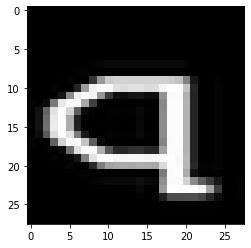

In [89]:
# Data visualization

# print classes
print(classes_collected)
# print label
index = 125
plt.imshow(data_train[index].reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes_collected[labels_train[index].item()])

In [90]:
batch_size = 64

train_set_digital = torch.utils.data.TensorDataset(data_train, labels_train)
val_set_digital = torch.utils.data.TensorDataset(data_val, labels_val)
test_set_digital = torch.utils.data.TensorDataset(data_test, labels_test)

train_loader_digital = torch.utils.data.DataLoader(train_set_digital, batch_size=batch_size, shuffle=True)
val_loader_digital = torch.utils.data.DataLoader(val_set_digital, batch_size=batch_size, shuffle=True)
test_loader_digital = torch.utils.data.DataLoader(test_set_digital, batch_size=batch_size, shuffle=True)

In [91]:
combined_batch_size=64

combined_train = []
combined_train_labels = []
combined_val = []
combined_val_labels = []
combined_test = []
combined_test_labels = []

for inputs, labels in combined_train_loader:
    for i in range(inputs.shape[0]):
        combined_train.append( inputs[i].detach().numpy() )
        combined_train_labels.append( labels[i].item() )
for inputs, labels in train_loader_digital:
    for i in range(inputs.shape[0]):
        combined_train.append( inputs[i].detach().numpy() )
        combined_train_labels.append( labels[i].item() )
        
for inputs, labels in combined_val_loader:
    for i in range(inputs.shape[0]):
        combined_val.append( inputs[i].detach().numpy() )
        combined_val_labels.append( labels[i].item() )
for inputs, labels in val_loader_digital:
    for i in range(inputs.shape[0]):
        combined_val.append( inputs[i].detach().numpy() )
        combined_val_labels.append( labels[i].item() )
        
for inputs, labels in combined_test_loader:
    for i in range(inputs.shape[0]):
        combined_test.append( inputs[i].detach().numpy() )
        combined_test_labels.append( labels[i].item() )
for inputs, labels in test_loader_digital:
    for i in range(inputs.shape[0]):
        combined_test.append( inputs[i].detach().numpy() )
        combined_test_labels.append( labels[i].item() )

combined_train = np.array(combined_train)
combined_train_labels = np.array(combined_train_labels)
combined_val = np.array(combined_val)
combined_val_labels = np.array(combined_val_labels)
combined_test = np.array(combined_test)
combined_test_labels = np.array(combined_test_labels)

print(combined_train.shape)
print(combined_train_labels.shape)
print(combined_val.shape)
print(combined_val_labels.shape)
print(combined_test.shape)
print(combined_test_labels.shape)

combined_train = torch.Tensor(combined_train)
combined_train_labels = torch.Tensor(combined_train_labels)

combined_val = torch.Tensor(combined_val)
combined_val_labels = torch.Tensor(combined_val_labels)

combined_test = torch.Tensor(combined_test)
combined_test_labels = torch.Tensor(combined_test_labels)

cobined_train_set = torch.utils.data.TensorDataset(combined_train, combined_train_labels)
combined_train_digital_loader = torch.utils.data.DataLoader(cobined_train_set, batch_size=combined_batch_size, shuffle=True)

cobined_val_set = torch.utils.data.TensorDataset(combined_val, combined_val_labels)
combined_val_digital_loader = torch.utils.data.DataLoader(cobined_val_set, batch_size=combined_batch_size, shuffle=True)

cobined_test_set = torch.utils.data.TensorDataset(combined_test, combined_test_labels)
combined_test_digital_loader = torch.utils.data.DataLoader(cobined_test_set, batch_size=combined_batch_size, shuffle=True)

print(len(combined_train_digital_loader))
print(len(combined_val_digital_loader))
print(len(combined_test_digital_loader))

(52780, 1, 28, 28)
(52780,)
(14890, 1, 28, 28)
(14890,)
(22048, 1, 28, 28)
(22048,)
825
233
345


In [92]:
model_digital = letterCNN(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_digital.parameters(), lr=1e-3)
train_network(model_digital, combined_train_digital_loader, combined_val_digital_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.29926
   Val loss: 0.94409

EPOCH 1
 Train loss: 0.75805
   Val loss: 0.78495

EPOCH 2
 Train loss: 0.61741
   Val loss: 0.72486

EPOCH 3
 Train loss: 0.54497
   Val loss: 0.70413

EPOCH 4
 Train loss: 0.49794
   Val loss: 0.68886

EPOCH 5
 Train loss: 0.46684
   Val loss: 0.69040

EPOCH 6
 Train loss: 0.44041
   Val loss: 0.67935

EPOCH 7
 Train loss: 0.41486
   Val loss: 0.67960

EPOCH 8
 Train loss: 0.39910
   Val loss: 0.68050

EPOCH 9
 Train loss: 0.38357
   Val loss: 0.67385



Test accuracy: 84.810


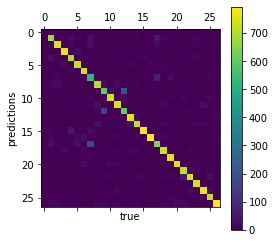

In [93]:
acc, true, pred = test_network(model_digital, combined_test_digital_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_digital.classes), pred, true)

### 1b) Regularization through dropout

In [94]:
class letterCNNDropout(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

In [95]:
# Testing the model above, TODO remove before submission
model_test = letterCNNDropout(classes_collected)
for inputs, labels in train_loader_collected:
    print(inputs.shape)
    print(labels.shape)
    print(inputs.dtype, labels.dtype)
    outputs = model_test.forward(inputs)
    print(outputs.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.float32 torch.int64
torch.Size([64, 27])


In [96]:
model_dropout = letterCNNDropout(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=1e-3)
train_network(model_dropout, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.35187
   Val loss: 1.07811

EPOCH 1
 Train loss: 0.90698
   Val loss: 0.94053

EPOCH 2
 Train loss: 0.77025
   Val loss: 0.86742

EPOCH 3
 Train loss: 0.67604
   Val loss: 0.82890

EPOCH 4
 Train loss: 0.60566
   Val loss: 0.78560

EPOCH 5
 Train loss: 0.55673
   Val loss: 0.78442

EPOCH 6
 Train loss: 0.52148
   Val loss: 0.75142

EPOCH 7
 Train loss: 0.49744
   Val loss: 0.74392

EPOCH 8
 Train loss: 0.47629
   Val loss: 0.74358

EPOCH 9
 Train loss: 0.45804
   Val loss: 0.73301



Test accuracy: 82.841


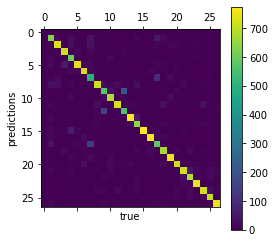

In [97]:
acc, true, pred = test_network(model_dropout, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_dropout.classes), pred, true)

### 1c) Regularization through Average Pooling

In [132]:
class letterCNNAvgPool(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.AvgPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

In [133]:
# Testing the model above, TODO remove before submission
model_test = letterCNNAvgPool(classes_collected)
for inputs, labels in train_loader_collected:
    print(inputs.shape)
    print(labels.shape)
    print(inputs.dtype, labels.dtype)
    outputs = model_test.forward(inputs)
    print(outputs.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.float32 torch.int64
torch.Size([64, 27])


In [100]:
model_avgpool = letterCNNAvgPool(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_avgpool.parameters(), lr=1e-3)
train_network(model_avgpool, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.38812
   Val loss: 1.11802

EPOCH 1
 Train loss: 0.87410
   Val loss: 0.87058

EPOCH 2
 Train loss: 0.67954
   Val loss: 0.81096

EPOCH 3
 Train loss: 0.58831
   Val loss: 0.78798

EPOCH 4
 Train loss: 0.53419
   Val loss: 0.77025

EPOCH 5
 Train loss: 0.49768
   Val loss: 0.76649

EPOCH 6
 Train loss: 0.46873
   Val loss: 0.74187

EPOCH 7
 Train loss: 0.44289
   Val loss: 0.74513

EPOCH 8
 Train loss: 0.42327
   Val loss: 0.74891

EPOCH 9
 Train loss: 0.40370
   Val loss: 0.73448



Test accuracy: 83.605


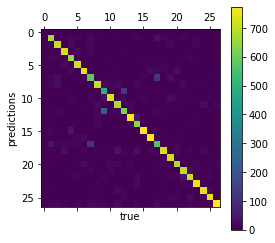

In [107]:
acc, true, pred = test_network(model_avgpool, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_avgpool.classes), pred, true)

### 1d) Regularization through Early Stopping

In [114]:
def train_network_early_stopping(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    prev_val_losses = [0] * 5
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model.forward(inputs)
                labels = labels.type(torch.long)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model.forward(inputs)
                    labels = labels.type(torch.long)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                prev_val_losses[epoch % 5] = total_loss/count
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            if epoch > 5:
                prev_error_mean = sum(prev_val_losses) / len(prev_val_losses)
                if prev_error_mean > 0.80:
                    # implementing early stopping for regularization
                    # note that 0.65 here is a hyperparameter
                    print('Early stopping in epoch ' + str(epoch) + ' because the average of last 5 validation error was ' + str(prev_error_mean))
                    break
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

In [115]:
model_early_stopping = letterCNN(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_early_stopping.parameters(), lr=1e-3)
train_network_early_stopping(model_early_stopping, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=50)

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.22875
   Val loss: 0.94236

EPOCH 1
 Train loss: 0.72867
   Val loss: 0.79194

EPOCH 2
 Train loss: 0.59136
   Val loss: 0.72480

EPOCH 3
 Train loss: 0.51755
   Val loss: 0.69778

EPOCH 4
 Train loss: 0.47059
   Val loss: 0.69379

EPOCH 5
 Train loss: 0.43606
   Val loss: 0.69208

EPOCH 6
 Train loss: 0.40962
   Val loss: 0.68342

EPOCH 7
 Train loss: 0.38562
   Val loss: 0.67404

EPOCH 8
 Train loss: 0.36843
   Val loss: 0.68288

EPOCH 9
 Train loss: 0.35232
   Val loss: 0.68439

EPOCH 10
 Train loss: 0.33676
   Val loss: 0.69446

EPOCH 11
 Train loss: 0.32380
   Val loss: 0.69565

EPOCH 12
 Train loss: 0.31301
   Val loss: 0.70968

EPOCH 13
 Train loss: 0.30343
   Val loss: 0.70069

EPOCH 14
 Train loss: 0.29496
   Val loss: 0.71390

EPOCH 15
 Train loss: 0.28404
   Val loss: 0.72711

EPOCH 16
 Train loss: 0.27770
   Val loss: 0.73292

EPOCH 17
 Train loss: 0.27161
   Val loss: 0.73080

EPOCH 18
 Train loss: 0.26146
   Val loss: 0.75122

EPOCH 19
 Train loss: 

Test accuracy: 84.917


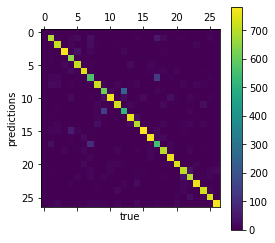

In [116]:
acc, true, pred = test_network(model_early_stopping, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_early_stopping.classes), pred, true)

## Computational Experiment 2 - Architecture

### Smaller Kernel Size

In [17]:
class modelCMS(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1352, len(self.classes))
        )
            

    def forward(self, x):
        return self.layers(x)

In [18]:
model1s = modelCMS(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1s.parameters(), lr=.001)
train_network(model1s, train_loader, val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.23041
   Val loss: 0.97628

EPOCH 1
 Train loss: 0.87156
   Val loss: 0.82428

EPOCH 2
 Train loss: 0.71721
   Val loss: 0.68793

EPOCH 3
 Train loss: 0.61153
   Val loss: 0.61068

EPOCH 4
 Train loss: 0.54508
   Val loss: 0.57422

EPOCH 5
 Train loss: 0.50417
   Val loss: 0.53292

EPOCH 6
 Train loss: 0.47292
   Val loss: 0.50506

EPOCH 7
 Train loss: 0.44726
   Val loss: 0.50167

EPOCH 8
 Train loss: 0.42715
   Val loss: 0.48336

EPOCH 9
 Train loss: 0.40840
   Val loss: 0.46216



Test accuracy: 85.981


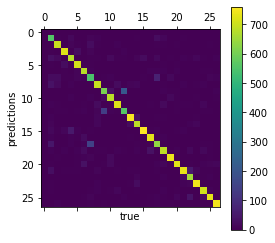

In [19]:
acc, true, pred = test_network(model1s, test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model1s.classes), pred, true)

### Double Convolutional Layer

[]

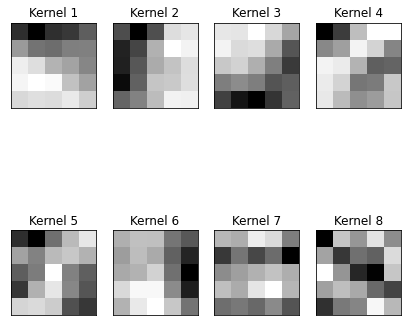

In [142]:
# first, extract the weights from the learned model
conv1wt = model2.layers[0].weight.data.numpy()

# then, visualize them!
_, axes = plt.subplots(2, 4, figsize=(7,7))
kernel = 0
for i in range(2):
    for j in range(4):
        axes[i,j].matshow(conv1wt.squeeze()[kernel], cmap='gray')
        kernel += 1
        title = 'Kernel ' + str(kernel)
        axes[i,j].set_title(title)
plt.setp(axes, xticks=[], yticks=[])

In [143]:
class letterCNNDouble(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, len(self.classes))
        )
            
    def forward(self, x):
        return self.layers(x)

In [144]:
model_double_layer = letterCNNDouble(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_double_layer.parameters(), lr=1e-3)
train_network(model_double_layer, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.99217
   Val loss: 0.66006

EPOCH 1
 Train loss: 0.42931
   Val loss: 0.52464

EPOCH 2
 Train loss: 0.31952
   Val loss: 0.52790

EPOCH 3
 Train loss: 0.26398
   Val loss: 0.46270

EPOCH 4
 Train loss: 0.22833
   Val loss: 0.44597

EPOCH 5
 Train loss: 0.20508
   Val loss: 0.45339

EPOCH 6
 Train loss: 0.18317
   Val loss: 0.46079

EPOCH 7
 Train loss: 0.16793
   Val loss: 0.45281

EPOCH 8
 Train loss: 0.15031
   Val loss: 0.46952

EPOCH 9
 Train loss: 0.13975
   Val loss: 0.50114



Test accuracy: 89.430


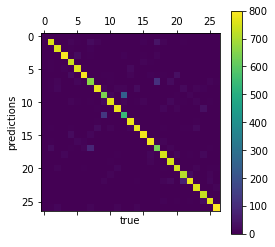

In [145]:
acc, true, pred = test_network(model_double_layer, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_double_layer.classes), pred, true)

(64, 8, 5, 5)
(8, 5, 5)


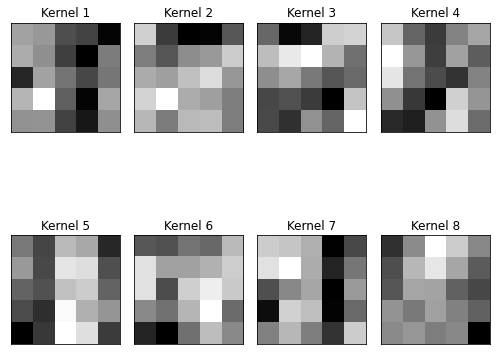

In [163]:
# first, extract the weights from the learned model
conv2wts = model_double_layer.layers[3].weight.data.numpy()
print(conv2wts.shape)
conv2wt = conv2wts[0]
print(conv2wt.shape)

# then, visualize them!
_, axes = plt.subplots(2, 4, figsize=(7,7))
kernel = 0
for i in range(2):
    for j in range(4):
        img = conv2wt[kernel]
#         print(img.shape)
        axes[i,j].matshow(img, cmap='gray')
        kernel += 1
        title = 'Kernel ' + str(kernel)
        axes[i,j].set_title(title)
plt.setp(axes, xticks=[], yticks=[])
plt.tight_layout()

In [ ]:
# first, extract the weights from the learned model
conv2wts = model_double_layer.layers[3].weight.data.numpy()
print(conv2wts.shape)

# then, visualize them!
_, axes = plt.subplots(8, 8, figsize=(7,7))
kernel = 0
for i in range(8):
    for j in range(8):
        img = conv2wt[kernel]
#         print(img.shape)
        axes[i,j].matshow(img, cmap='gray')
        kernel += 1
        title = 'Kernel ' + str(kernel)
        axes[i,j].set_title(title)
plt.setp(axes, xticks=[], yticks=[])
plt.tight_layout()

## Visualizing Learned Kernels

(8, 1, 5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)


[]

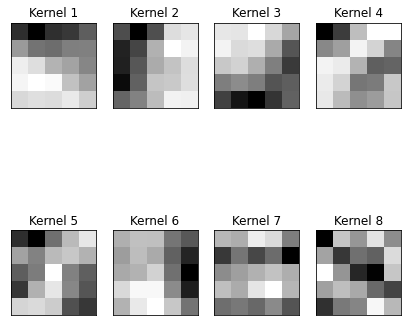

In [153]:
# first, extract the weights from the learned model
conv1wt = model2.layers[0].weight.data.numpy()
print(conv1wt.shape)

# then, visualize them!
_, axes = plt.subplots(2, 4, figsize=(7,7))
kernel = 0
for i in range(2):
    for j in range(4):
        img = conv1wt.squeeze()[kernel]
        print(img.shape)
        axes[i,j].matshow(conv1wt.squeeze()[kernel], cmap='gray')
        kernel += 1
        title = 'Kernel ' + str(kernel)
        axes[i,j].set_title(title)
plt.setp(axes, xticks=[], yticks=[])

## Visualizing Optimized Inputs

In [135]:
class OptimizeInput(nn.Module):
    def __init__(self, learned_model, input_shape=(1, 1, 28, 28)):
        super().__init__()
        self.learned_model = learned_model
        self.optimized_input = torch.zeros(input_shape, requires_grad=True)
        
    def forward(self):
        return self.learned_model(self.optimized_input)
    
    def parameters(self):
        return [self.optimized_input]

In [136]:
# Given model, get optimized input for each character
def get_optimized_inputs(model, nepochs = 10000):
    targets = torch.arange(len(model.classes)).long()
    optimized_inputs = {}

    for t in targets:
        # train input
        input_model = OptimizeInput(model)
        optimizer = torch.optim.Adam(input_model.parameters(), lr=.01)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(nepochs):
            optimizer.zero_grad()
            outputs = input_model()
            loss = criterion(outputs, t.reshape(1))
            loss.backward()
            optimizer.step()
        print("finished %s with %0.5f loss" % (model.classes[t], loss.item()), end = "\t")
        optimized_inputs[model.classes[t]] = input_model.optimized_input.detach().numpy().reshape((28, 28))
        
        # test input
        tensor = torch.Tensor(optimized_inputs[model.classes[t]].reshape(1, 1, 28, 28))
        with torch.no_grad():
            output = model(tensor)
        prob = output.squeeze().detach().numpy()
        pred = model.classes[torch.argmax(output, dim=1)]
        print(f"Expected: {model.classes[t]}. Predicted: {pred}.")
    return optimized_inputs

In [137]:
optimized_inputs = get_optimized_inputs(model2, nepochs=1000)

finished N/A with 0.00311 loss	Expected: N/A. Predicted: N/A.
finished a with 0.00003 loss	Expected: a. Predicted: a.
finished b with 0.00002 loss	Expected: b. Predicted: b.
finished c with 0.00001 loss	Expected: c. Predicted: c.
finished d with 0.00002 loss	Expected: d. Predicted: d.
finished e with 0.00002 loss	Expected: e. Predicted: e.
finished f with 0.00000 loss	Expected: f. Predicted: f.
finished g with 0.00001 loss	Expected: g. Predicted: g.
finished h with 0.00001 loss	Expected: h. Predicted: h.
finished i with 0.00000 loss	Expected: i. Predicted: i.
finished j with 0.00000 loss	Expected: j. Predicted: j.
finished k with 0.00000 loss	Expected: k. Predicted: k.
finished l with 0.00001 loss	Expected: l. Predicted: l.
finished m with 0.00000 loss	Expected: m. Predicted: m.
finished n with 0.00003 loss	Expected: n. Predicted: n.
finished o with 0.00002 loss	Expected: o. Predicted: o.
finished p with 0.00001 loss	Expected: p. Predicted: p.
finished q with 0.00005 loss	Expected: q. 

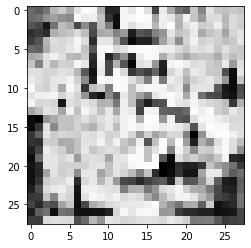

In [138]:
letter = 'b'
letter_visualized = optimized_inputs[letter].T
plt.imshow(letter_visualized, cmap='Greys_r')